In [1]:
using CSV, DataFrames, PyPlot, PyCall, StatsBase, ScikitLearn, Statistics
import ScikitLearn.CrossValidation: train_test_split, KFold

plt.style.use("dark_background")
sns = pyimport("seaborn")
sns.set_context("notebook")
sns.set_palette("muted")
rcParams = PyDict(matplotlib.rcParams)
rcParams["axes.facecolor"] = "None"

ENV["COLUMNS"] = 300;

use k folds instead

Method (Using https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
Try again without one-hot per [this](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/) article

* Regression
* Total samples 6497 < 100k
* 12 features... doesn't feel like "few"
* Linear SVR, and SVR with "rbf" kernel if LSVR "doesn't work"

Steps:
* Read in data
* Visualize data
* Shape data for sklearn
* Figure out which input variables are least important
  * Regression with all data
  * https://blog.minitab.com/blog/adventures-in-statistics-2/how-to-identify-the-most-important-predictor-variables-in-regression-models
  * Repeat regression with all but the ith input variable
      * track $\Delta R^{2}$
* Reduce data
* Investigate best train/test split
* 

**try LinearSVR and Linear regression**

## Define Colors
You can't have good data viz without a decent palette

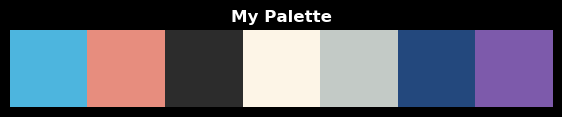

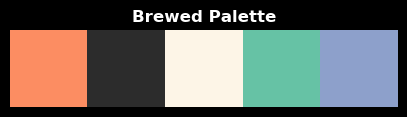

In [2]:
# from colorbrewer, with face and dark colors added by me. They don't appear
# to be black-and-white safe
brewed_colors = Dict(
    :green => "#66c2a5",
    :red =>"#fc8d62",
    :blue => "#8da0cb",
    :face => "#fdf5e7",
    :dark => "#2c2c2c"
)

# colors that I think look nice together, which are black-and-white safe
# (different gray levels when desaturated) as well as colorblind safe per
# investigation via gimp's colorblind simulation filters
my_colors = Dict(
    :face => "#fdf5e7",
    :dark => "#2c2c2c",
    :red => "#e78d7e",
    :lt_blue => "#4db5de",
    :dk_blue => "#23487d",
    :purple => "#7d5aab",
    :gray => "#c3cac6"
)
fig = figure()
sns.palplot([my_colors[c] for c in keys(my_colors)])
fig.set_facecolor("r")
title("My Palette", weight="bold")
axis("off")
figure()
sns.palplot([brewed_colors[c] for c in keys(brewed_colors)])
title("Brewed Palette", weight="bold")
axis("off");

## Load Data
Load in red and white wine dataframes, check for the correct number of entries, and combine into a single dataframe

In [3]:
df_red = CSV.read("winequality-red.csv")
n_red = nrow(df_red)
@assert n_red == 1599

df_white = CSV.read("winequality-white.csv")
n_white = nrow(df_white)
@assert n_white == 4898
@assert names(df_red) == names(df_white)

# df_red.red = ones(Int, n_red)
# df_red.white = zeros(Int, n_red)
# df_white.red = zeros(Int, n_white)
# df_white.white = ones(Int, n_white)

df = [df_red; df_white]
n_wines = n_red + n_white
(df_red, df_white) = (nothing, nothing);

## Visualise data distributions

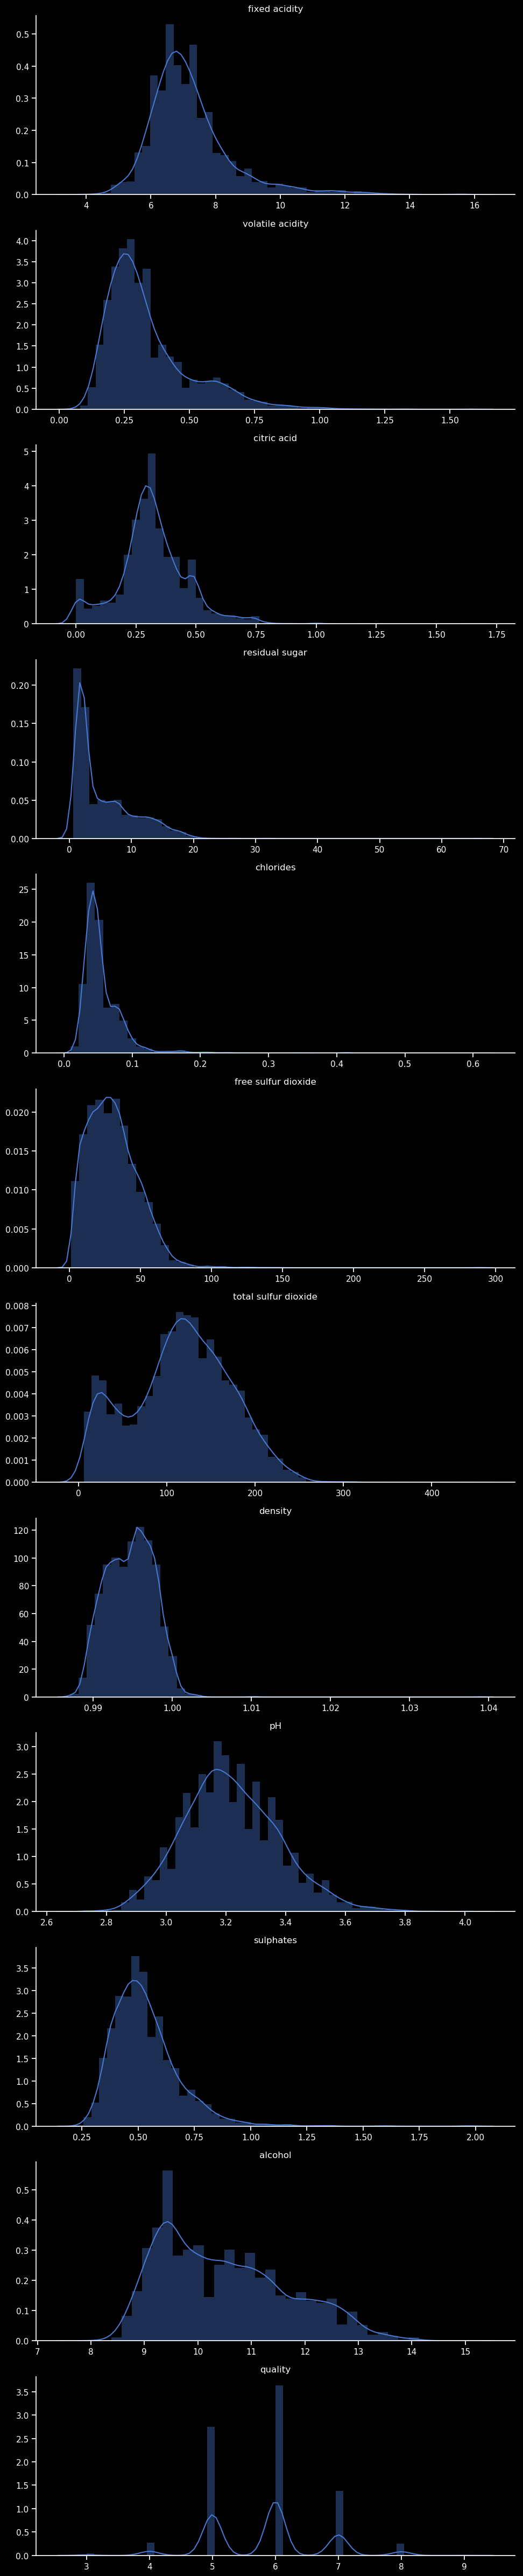

In [4]:
n_col = ncol(df)
fig, ax = subplots(n_col, 1, figsize=(10, 4*n_col))
for (i, key) in enumerate(names(df))
    sns.distplot(df[!, key], ax=ax[i])
    ax[i].set_title(key)
end
sns.despine()
tight_layout()

None of this appears to vary too much, so I'm not going to worry about scaling the features.

[Resource](https://medium.com/analytics-vidhya/from-data-pre-processing-to-optimizing-a-regression-model-performance-47fe3b086ac9) describing pre-processing flow, including one-hot encoding (such as used here for wine color) and scaling.

### Reshape data for sklearn

In [5]:
features = [n for n in names(df) if n != :quality]
n_features = length(features)
X = ones(n_wines, n_features) * NaN
y = df[!, :quality]
for (i, f) in enumerate(features)
    X[:, i] = df[!, f]
end

## Split Data
We were asked to do a parity plot *and* use K-folds cross-validation. I don't know how to do a parity plot without withholding some data, so my plan is to use 90% of the data to tune hyperparameters and train the model, and use the final 10% to build the parity plot.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.9,
    shuffle=true
)
folds = KFold(
    length(y_train),
    n_folds=10,
    shuffle=true
)
println("Data Separated")
println()
println("test points\t\t", length(X_test))
println("train points\t\t", length(X_train))

Data Separated

test points		7150
train points		64317


## Scale and transform data using PCA

[Here](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)

In [7]:
@sk_import preprocessing: StandardScaler
scl = StandardScaler()
scl.fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test);

In [8]:
@sk_import decomposition: PCA
pca = PCA(0.95)
pca.fit(X_train)
println("Original dataset: ", size(X_train)[2], " variables")
println("Reduced dataset:  ", pca.n_components_, " variables")
X_train = pca.transform(X_train)
X_test = pca.transform(X_test);

Original dataset: 11 variables
Reduced dataset:  9 variables


## Investigate Regression Models
I'm taking the shotgun approach at first with a bunch of regressors I found in the scikit-learn documentation. This is probably advantageous given that we have covered SVR and linear regression, but have not had a chance to discuss most of these models. In order to give myself an idea of how they perform on this data set, I will evaluate them using `train` and `test` data partitions. These were intended to be used only for creating parity plots, and perhaps this isn't best practice, but I think it is prudent given my limited knowledge. My laptop, on the other hand, is unhappy about this.

From this, it seems that the top 3 estimators clearly outperform the others. Let's take a closer look at them.

## I... really should be classifying
[Here](https://scikit-learn.org/stable/modules/multiclass.html) is a list of inherently multiclass classifiers from the sklearn documentation

In [9]:
@sk_import naive_bayes: BernoulliNB
@sk_import tree: DecisionTreeClassifier
@sk_import tree: ExtraTreeClassifier
@sk_import naive_bayes: GaussianNB
@sk_import ensemble: ExtraTreesClassifier
@sk_import neighbors: KNeighborsClassifier
@sk_import semi_supervised: LabelPropagation
@sk_import semi_supervised: LabelSpreading
@sk_import discriminant_analysis: LinearDiscriminantAnalysis
@sk_import svm: LinearSVC
# @sk_import linear_model: LogisticRegression
# @sk_import linear_model: LogisticRegressionCV
@sk_import neural_network : MLPClassifier
@sk_import neighbors: NearestCentroid
@sk_import discriminant_analysis: QuadraticDiscriminantAnalysis
@sk_import neighbors: RadiusNeighborsClassifier
@sk_import linear_model: RidgeClassifier
@sk_import linear_model: RidgeClassifierCV

classifiers = DataFrame(
    name=[
        "BernoulliNB",
        "DecisionTreeClassifier",
        "ExtraTreeClassifier",
        "GaussianNB",
        "ExtraTreesClassifier",
        "KNeighborsClassifier",
        "LabelPropagation",
        "LabelSpreading",
        "LinearDiscriminantAnalysis",
        "LinearSVC",
#         "LogisticRegression",
#         "LogisticRegressionCV",
        "MLPClassifier",
        "NearestCentroid",
        "QuadraticDiscriminantAnalysis",
        "RadiusNeighborsClassifier",
        "RidgeClassifier",
        "RidgeClassifierCV",
        ],
    cls=[
        BernoulliNB(),
        DecisionTreeClassifier(),
        ExtraTreeClassifier(),
        GaussianNB(),
        ExtraTreesClassifier(),
        KNeighborsClassifier(),
        LabelPropagation(),
        LabelSpreading(),
        LinearDiscriminantAnalysis(),
        LinearSVC(multi_class="crammer_singer"),
#         LogisticRegression(multi_class="multinomial"),
#         LogisticRegressionCV(multi_class="multinomial"),
        MLPClassifier(),
        NearestCentroid(),
        QuadraticDiscriminantAnalysis(),
        RadiusNeighborsClassifier(radius=10),
        RidgeClassifier(),
        RidgeClassifierCV(),
    ]
)
n_cls = nrow(classifiers)
classifiers[!, :score] = [NaN for _ in 1:n_cls]
for i in 1:n_cls
    cls = classifiers[i, :cls]
    cls.fit(X_train, y_train)
    score = cls.score(X_test, y_test)
    classifiers[i, :score] = score >= 0.0 ? score : NaN
end
filter!(row->!isnan(row[:score]), classifiers)
sort!(classifiers, :score, rev=true);

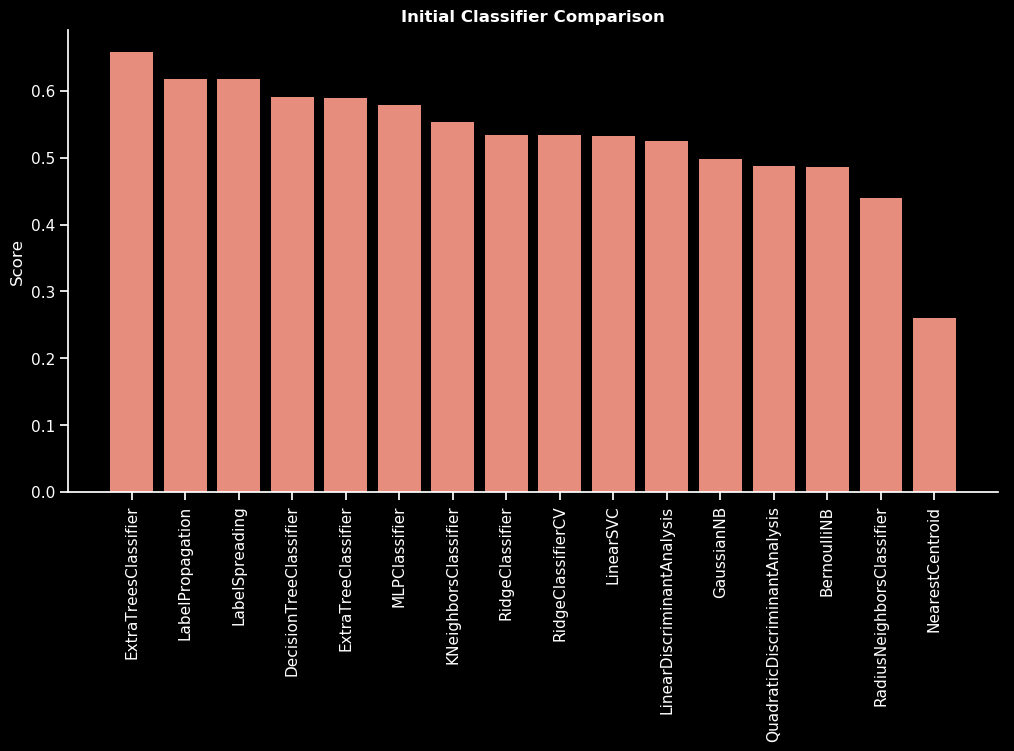

In [10]:
fig, ax = subplots(figsize=(12, 6))
ax.bar(classifiers[!, :name], classifiers[!, :score], color=my_colors[:red])
ax.set_ylabel("Score")
ax.set_title("Initial Classifier Comparison", weight="bold")

xticks(rotation=90)
sns.despine()

Moving forward, use the ExtraTreesClassifier

## Tune hyperparameters
[Docs](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters)

In [11]:
using ScikitLearn.GridSearch: GridSearchCV
using ScikitLearn: fit!
n_estimators = 10 .^ range(0, stop=3)
max_features = ["auto", "log2", nothing]
min_samples_split = [2, 5, 10, 15]
bootstrap = [true, false]

reg = ExtraTreesClassifier(n_jobs=-1)
gsc = GridSearchCV(
    estimator=reg,
    param_grid=Dict(
        :n_estimators => n_estimators,
        :max_features => max_features,
        :min_samples_split => min_samples_split,
        :bootstrap => bootstrap
    ),
    cv=5,
)
fit!(gsc, X_train, y_train)

GridSearchCV
  estimator: PyObject
  param_grid: Dict{Symbol,Array{T,1} where T}
  scoring: Nothing nothing
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any,Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Int64 5
  verbose: Int64 0
  error_score: String "raise"
  scorer_: score (function of type typeof(ScikitLearnBase.score))
  best_params_: Dict{Symbol,Any}
  best_score_: Float64 0.6904395416452882
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((96,))
  best_estimator_: PyObject


In [12]:
gsc.best_params_

Dict{Symbol,Any} with 4 entries:
  :max_features      => nothing
  :min_samples_split => 5
  :n_estimators      => 1000
  :bootstrap         => true

## Fit model

Since cross-validation was covered during the grid search, I won't worry about doing it manually to assess the model accuracy

In [14]:
cls = ExtraTreesClassifier(
    max_features=nothing,
    min_samples_split=5,
    n_estimators=1000,
    bootstrap=true,
    n_jobs=-1
)
cls.fit(X_train, y_train)

PyObject ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
                     max_depth=None, max_features=None, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

## Validate model

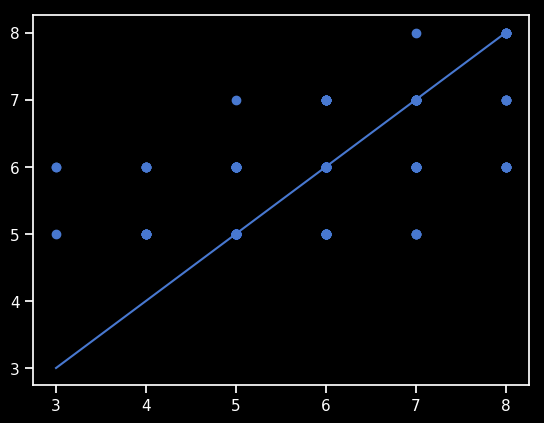

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2335c03fd0>

In [26]:
scatter(y_test, cls.predict(X_test), cmap="Greens")
plot([3, 8], [3, 8])